In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
np.random.seed(0)

In [3]:
rides = pd.read_csv('Bike-Sharing-Dataset/hour.csv')

rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [5]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

In [6]:
# Save data for approximately the last 21 days 
test = data[-21*24:]
y_test = test['cnt']
X_test = test.drop(['casual', 'registered', 'cnt'], axis=1)
# Now remove the test data from the data set 
data = data[:-21*24]
y = data['cnt']
X = data.drop(['casual', 'registered', 'cnt'], axis=1)

In [18]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=56))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error',
              optimizer='sgd');

hist = model.fit(np.array(X),  np.array(y),  validation_split=0.3, 
          epochs=25,
          batch_size=16);

Train on 11812 samples, validate on 5063 samples
Epoch 1/25
11812/11812 [==============================] - 2s - loss: 0.6929 - val_loss: 1.7650
Epoch 2/25
11812/11812 [==============================] - 2s - loss: 0.5380 - val_loss: 1.2350
Epoch 3/25
11812/11812 [==============================] - 2s - loss: 0.4762 - val_loss: 1.0700
Epoch 4/25
11812/11812 [==============================] - 2s - loss: 0.4140 - val_loss: 0.9294
Epoch 5/25
11812/11812 [==============================] - 2s - loss: 0.3537 - val_loss: 0.7363
Epoch 6/25
11812/11812 [==============================] - 2s - loss: 0.3060 - val_loss: 0.6366
Epoch 7/25
11812/11812 [==============================] - 2s - loss: 0.2809 - val_loss: 0.5820
Epoch 8/25
11812/11812 [==============================] - 2s - loss: 0.2614 - val_loss: 0.5432
Epoch 9/25
11812/11812 [==============================] - 2s - loss: 0.2454 - val_loss: 0.5045
Epoch 10/25
11812/11812 [==============================] - 2s - loss: 0.2302 - val_loss: 0.4868


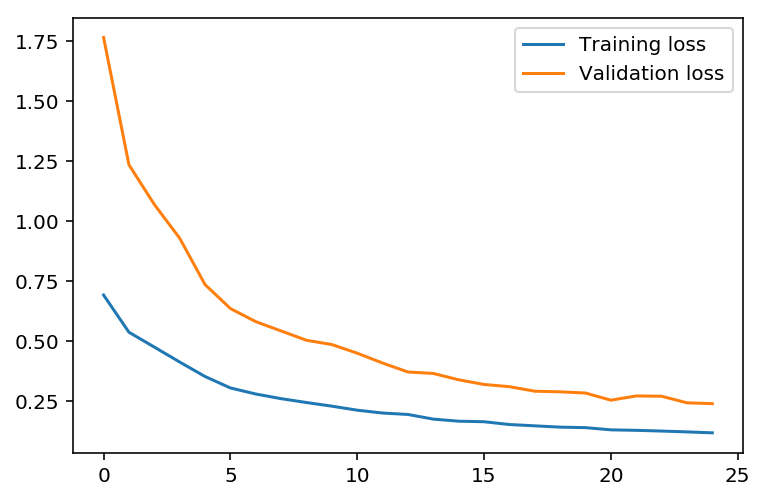

In [19]:
plt.plot(hist.history['loss'], label='Training loss')
plt.plot(hist.history['val_loss'], label='Validation loss')
plt.legend()
_ = plt.ylim()

In [20]:
score = model.evaluate(np.array(X_test), np.array(y_test),verbose=0)
score

0.16084685022868808

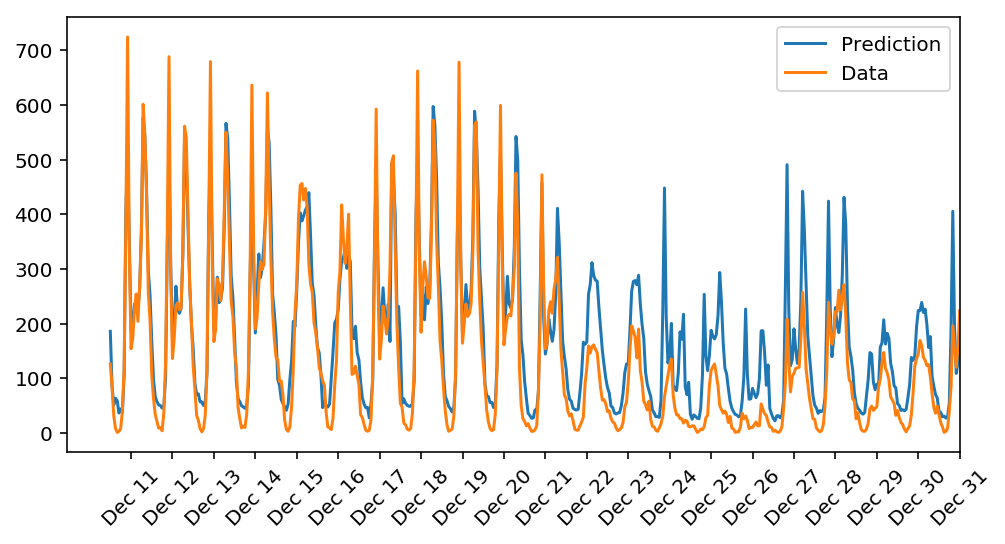

In [21]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = model.predict(np.array(X_test), batch_size=16).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((y_test*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.loc[test.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)